In [1]:
from qiskit import pulse, circuit, transpile, assemble, schedule, IBMQ, QuantumCircuit, quantum_info as qi 
import qiskit
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.visualization.pulse_v2 import draw
from qiskit.pulse import ShiftPhase, GaussianSquare, Drag, ControlChannel, MeasureChannel, DriveChannel, Play, Schedule
import numpy as np
from qiskit.tools import job_monitor
from copy import deepcopy
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
account_provider = IBMQ.load_account()
provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}

# target backend
backend_name = 'ibmq_jakarta'

provider = IBMQ.get_provider(**provider_opts)
backend = provider.get_backend(backend_name)

# backend information
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# instruction schedule map
inst_map = defaults.instruction_schedule_map

In [237]:
qubit = 0
freq01_estimate = backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate -15e6, freq01_estimate + 15e6, 51)

In [256]:
print(freq01_estimate)

5236358802.651813


In [238]:
print(frequencies)

[5.2213588e+09 5.2219588e+09 5.2225588e+09 5.2231588e+09 5.2237588e+09
 5.2243588e+09 5.2249588e+09 5.2255588e+09 5.2261588e+09 5.2267588e+09
 5.2273588e+09 5.2279588e+09 5.2285588e+09 5.2291588e+09 5.2297588e+09
 5.2303588e+09 5.2309588e+09 5.2315588e+09 5.2321588e+09 5.2327588e+09
 5.2333588e+09 5.2339588e+09 5.2345588e+09 5.2351588e+09 5.2357588e+09
 5.2363588e+09 5.2369588e+09 5.2375588e+09 5.2381588e+09 5.2387588e+09
 5.2393588e+09 5.2399588e+09 5.2405588e+09 5.2411588e+09 5.2417588e+09
 5.2423588e+09 5.2429588e+09 5.2435588e+09 5.2441588e+09 5.2447588e+09
 5.2453588e+09 5.2459588e+09 5.2465588e+09 5.2471588e+09 5.2477588e+09
 5.2483588e+09 5.2489588e+09 5.2495588e+09 5.2501588e+09 5.2507588e+09
 5.2513588e+09]


In [349]:
def spectroscopy_scheds(qubit, pulse_params, backend):
    freq_param = circuit.Parameter("frequency")
    with pulse.build(backend=backend, name="spectroscopy") as schedule:
        pulse.shift_frequency(freq_param, DriveChannel(qubit))
        pulse.play(
            GaussianSquare(duration=pulse_params["duration"], 
                           amp=pulse_params["amp"], 
                           sigma=pulse_params["sigma"], 
                           width=pulse_params["width"]), DriveChannel(qubit))
        pulse.shift_frequency(-freq_param, DriveChannel(qubit))
        
    return schedule, freq_param

def amplitude_scheds(qubit, pulse_params, backend):
    amp_param = circuit.Parameter("amp")
    with pulse.build(backend=backend, name="amp_sweep") as schedule:
        pulse.set_frequency(pulse_params["frequency"], 
                            DriveChannel(qubit))
        pulse.play(
            Drag(duration=pulse_params['duration'], 
                           amp=amp_param, 
                           sigma=pulse_params["sigma"], 
                           beta=pulse_params["beta"]), DriveChannel(qubit))
    return schedule, amp_param

def x_gate_scheds(qubit, pulse_params, backend):
    with pulse.build(backend=backend, name="x_gate") as schedule:
        pulse.set_frequency(pulse_params["frequency"], 
                            DriveChannel(qubit))
        pulse.play(
            Drag(duration=pulse_params['duration'], 
                           amp=pulse_params["amplitude"], 
                           sigma=pulse_params["sigma"], 
                           beta=pulse_params["beta"]), DriveChannel(qubit))
    return schedule

def template_circuit(param, gate_name):
    temp_circ = QuantumCircuit(1)
    if param is not None:
        temp_circ.append(circuit.Gate(name=gate_name, num_qubits=1, params=[param]), (0,))
        temp_circ.measure_active()
    else:
        temp_circ.append(circuit.Gate(name=gate_name, num_qubits=1, params=[]), (0,))
    return temp_circ

def spectroscopy_circuits(qubit, frequencies, pulse_params, backend):
    gname = "Spec"
    sched, freq_param = spectroscopy_scheds(qubit, pulse_params, backend)
    circuit = template_circuit(freq_param, gname)
    circuit.add_calibration(gname, (qubit,), sched, params=[freq_param])
    
    center_freq = backend.defaults().qubit_freq_est[qubit]
    
    circs = []
    for freq in frequencies:
        freq_shift = freq
        freq_shift -= center_freq
        freq_shift = np.round(freq_shift, decimals=3)
        assigned_circ = circuit.assign_parameters({freq_param: freq_shift}, inplace=False)
        circs.append(assigned_circ)
    return circs

def amplitude_circuits(qubit, amplitudes, pulse_params, backend):
    gname = "Amp"
    sched, amp_param = amplitude_scheds(qubit, pulse_params, backend)
    circuit = template_circuit(amp_param, gname)
    circuit.add_calibration(gname, (qubit,), sched, params=[amp_param])
    
    circs = []
    for amp in amplitudes:
        assigned_circ = circuit.assign_parameters({amp_param: amp}, inplace=False)
        circs.append(assigned_circ)
    return circs

def x_gate_circuits(qubit, pulse_params, backend):
    gname = "Custom_x"

    sched = x_gate_scheds(qubit, pulse_params, backend)
    circuit = template_circuit(None, gname)
    circuit.add_calibration(gname, (qubit,), sched)
    circs.append(circuit)
    
    return circuit

## Spectroscopy pulse parameters - using a GaussianSquare pulse to perform qubit spectroscopy

In [240]:
pulse_params = {}
pulse_params["duration"] = 1024
pulse_params["amp"] = 0.1
pulse_params["sigma"] = 256
pulse_params["width"] = 0


In [241]:
circs = spectroscopy_circuits(qubit, frequencies, pulse_params, backend)

In [242]:
transpiled_circs = transpile(circs, backend, initial_layout=[0])

In [243]:
# transpiled_circs[0].draw()

In [244]:
job = backend.run(transpiled_circs, job_name="spectroscopy", shots=2048)
job_id = job.job_id()
print(job.job_id())

619c7dc18982d9836e339a69


In [245]:
# 11/21/spectroscopy
# jakarta (11:51) 619a768168476d6e298a8394

# lagos (2:16) 619a9b38cd37f33609f2702d
# armonk (3:29) 619aac3a53ac6ccf4ad59760

#11/23/2021 
# lagos (12:03) 619c75f28982d995183399dc

# jakarta (12:36) 619c7dc18982d9836e339a69


# backend = provider.get_backend("ibmq_armonk")
results = backend.retrieve_job("619c7dc18982d9836e339a69").result()

In [246]:
print(results.get_counts())

[{'0': 2005, '1': 43}, {'0': 1998, '1': 50}, {'0': 2016, '1': 32}, {'0': 2015, '1': 33}, {'0': 2012, '1': 36}, {'0': 2003, '1': 45}, {'0': 1983, '1': 65}, {'0': 1961, '1': 87}, {'0': 1888, '1': 160}, {'0': 1854, '1': 194}, {'0': 1835, '1': 213}, {'0': 1832, '1': 216}, {'0': 1853, '1': 195}, {'0': 1870, '1': 178}, {'0': 1926, '1': 122}, {'0': 1974, '1': 74}, {'0': 2006, '1': 42}, {'0': 2018, '1': 30}, {'0': 1994, '1': 54}, {'0': 1965, '1': 83}, {'0': 1870, '1': 178}, {'0': 1794, '1': 254}, {'0': 1742, '1': 306}, {'0': 1654, '1': 394}, {'0': 1614, '1': 434}, {'0': 1602, '1': 446}, {'0': 1610, '1': 438}, {'0': 1634, '1': 414}, {'0': 1710, '1': 338}, {'0': 1758, '1': 290}, {'0': 1853, '1': 195}, {'0': 1923, '1': 125}, {'0': 1990, '1': 58}, {'0': 2003, '1': 45}, {'0': 2008, '1': 40}, {'0': 1987, '1': 61}, {'0': 1933, '1': 115}, {'0': 1909, '1': 139}, {'0': 1884, '1': 164}, {'0': 1857, '1': 191}, {'0': 1827, '1': 221}, {'0': 1871, '1': 177}, {'0': 1894, '1': 154}, {'0': 1928, '1': 120}, {'0'

In [247]:
exp_vals = []
for counts in results.get_counts():
    exp_val = 0
    for k,v in counts.items():
        if k == "1":
            exp_val = v/sum(counts.values())
    exp_vals.append(exp_val)
print(exp_vals)

[0.02099609375, 0.0244140625, 0.015625, 0.01611328125, 0.017578125, 0.02197265625, 0.03173828125, 0.04248046875, 0.078125, 0.0947265625, 0.10400390625, 0.10546875, 0.09521484375, 0.0869140625, 0.0595703125, 0.0361328125, 0.0205078125, 0.0146484375, 0.0263671875, 0.04052734375, 0.0869140625, 0.1240234375, 0.1494140625, 0.1923828125, 0.2119140625, 0.2177734375, 0.2138671875, 0.2021484375, 0.1650390625, 0.1416015625, 0.09521484375, 0.06103515625, 0.0283203125, 0.02197265625, 0.01953125, 0.02978515625, 0.05615234375, 0.06787109375, 0.080078125, 0.09326171875, 0.10791015625, 0.08642578125, 0.0751953125, 0.05859375, 0.0361328125, 0.0234375, 0.0224609375, 0.01318359375, 0.0185546875, 0.01611328125, 0.02685546875]


In [248]:
frequencies_GHz = frequencies*1e-9
print(frequencies_GHz)

[5.2213588 5.2219588 5.2225588 5.2231588 5.2237588 5.2243588 5.2249588
 5.2255588 5.2261588 5.2267588 5.2273588 5.2279588 5.2285588 5.2291588
 5.2297588 5.2303588 5.2309588 5.2315588 5.2321588 5.2327588 5.2333588
 5.2339588 5.2345588 5.2351588 5.2357588 5.2363588 5.2369588 5.2375588
 5.2381588 5.2387588 5.2393588 5.2399588 5.2405588 5.2411588 5.2417588
 5.2423588 5.2429588 5.2435588 5.2441588 5.2447588 5.2453588 5.2459588
 5.2465588 5.2471588 5.2477588 5.2483588 5.2489588 5.2495588 5.2501588
 5.2507588 5.2513588]


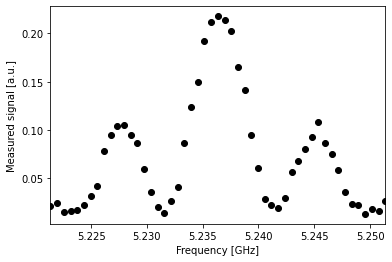

In [249]:
plt.scatter(frequencies_GHz, np.real(exp_vals), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 51
    # variables        = 3
    chi-square         = 0.07321489
    reduced chi-square = 0.00152531
    Akaike info crit   = -327.855288
    Bayesian info crit = -322.059811
[[Variables]]
    amplitude:  0.00217641 +/- 1.9988e-04 (9.18%) (init = 0.001841309)
    center:     5.23647285 +/- 3.0382e-04 (0.01%) (init = 5.236359)
    sigma:      0.00336175 +/- 4.3736e-04 (13.01%) (init = 0.0024)
    fwhm:       0.00672351 +/- 8.7472e-04 (13.01%) == '2.0000000*sigma'
    height:     0.20607510 +/- 0.01869013 (9.07%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.717


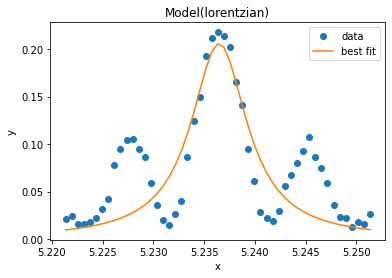

In [255]:
import lmfit

model = lmfit.models.LorentzianModel()
params = model.guess(np.array(exp_vals), x=np.array(frequencies_GHz))

result = model.fit(np.array(exp_vals), params, x=frequencies_GHz)
result.plot_fit()
print(result.fit_report())

In [259]:
qubit_frequency = result.params["center"].value
print(F"Our freq: {qubit_frequency} and reported: {freq01_estimate*1e-9}")

Our freq: 5.236472853419347 and reported: 5.236358802651813


In [279]:
x_sched = inst_map.get("x", qubit)

((0, Play(Drag(duration=160, amp=(0.1985878439739215+0j), sigma=40, beta=-0.9962676126094533, name='Xp_d0'), DriveChannel(0), name='Xp_d0')),)


In [287]:
drag_params = {}
drag_params["duration"] = x_sched.instructions[0][1].pulse.duration
drag_params["sigma"] = x_sched.instructions[0][1].pulse.sigma
drag_params["beta"] = x_sched.instructions[0][1].pulse.beta
drag_params["frequency"] = qubit_frequency*1.0e9

print(drag_params)

{'duration': 160, 'sigma': 40, 'beta': -0.9962676126094533, 'frequency': 5236472853.419347}


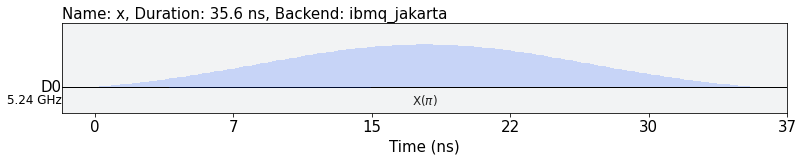

In [262]:
draw(x_sched, backend=backend)

In [263]:
amplitudes = np.linspace(-0.95, 0.95, 51)

In [264]:
amp_circs = amplitude_circuits(qubit, amplitudes, drag_params, backend)

In [265]:
transpiled_circs = transpile(amp_circs, backend, initial_layout=[0])

In [266]:
transpiled_circs[0].draw()

┌─────────────────────────┐ ░ ┌─┐
      q_0 -> 0 ┤ Amp(-0.950000000000000) ├─░─┤M├
               └─────────────────────────┘ ░ └╥┘
ancilla_0 -> 1 ───────────────────────────────╫─
                                              ║ 
ancilla_1 -> 2 ───────────────────────────────╫─
                                              ║ 
ancilla_2 -> 3 ───────────────────────────────╫─
                                              ║ 
ancilla_3 -> 4 ───────────────────────────────╫─
                                              ║ 
ancilla_4 -> 5 ───────────────────────────────╫─
                                              ║ 
ancilla_5 -> 6 ───────────────────────────────╫─
                                              ║ 
    measure: 1/═══════════════════════════════╩═
                                              0

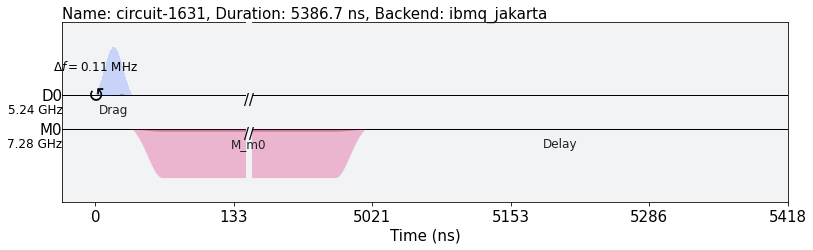

In [267]:
draw(schedule(transpiled_circs[50], backend), backend=backend)

In [268]:
job = backend.run(transpiled_circs, job_name="amplitude", shots=2048)
job_id = job.job_id()
print(job.job_id())

619c800853ac6c5c52d5a4c6


In [269]:
# 11/23/2021
# lagos (12:34) 619c7a2768476d433a8a9304

# jakarta (12:45) 619c800853ac6c5c52d5a4c6

results = backend.retrieve_job("619c800853ac6c5c52d5a4c6").result()

In [270]:
exp_vals = []
for counts in results.get_counts():
    exp_val = 0
    for k,v in counts.items():
        if k == "1":
            exp_val = v/sum(counts.values())
    exp_vals.append(exp_val)
print(exp_vals)

[0.7041015625, 0.4267578125, 0.2001953125, 0.04541015625, 0.02197265625, 0.1328125, 0.37060546875, 0.623046875, 0.86328125, 0.9775390625, 0.91650390625, 0.744140625, 0.4580078125, 0.2197265625, 0.05126953125, 0.02490234375, 0.1865234375, 0.416015625, 0.7119140625, 0.9072265625, 0.9638671875, 0.86572265625, 0.6318359375, 0.328125, 0.1064453125, 0.01123046875, 0.09375, 0.27880859375, 0.572265625, 0.82470703125, 0.96435546875, 0.91650390625, 0.734375, 0.455078125, 0.2099609375, 0.0419921875, 0.02978515625, 0.16845703125, 0.4375, 0.70849609375, 0.9033203125, 0.96533203125, 0.87353515625, 0.6796875, 0.431640625, 0.16845703125, 0.03125, 0.03271484375, 0.1923828125, 0.40087890625, 0.66455078125]


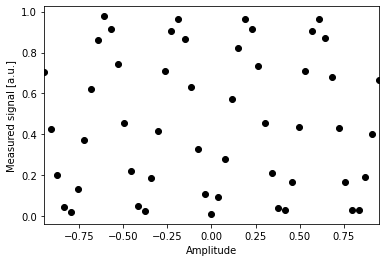

In [272]:
plt.scatter(amplitudes, np.real(exp_vals), color='black') # plot real part of sweep values
plt.xlim([min(amplitudes), max(amplitudes)])
plt.xlabel("Amplitude")
plt.ylabel("Measured signal [a.u.]")
plt.show()

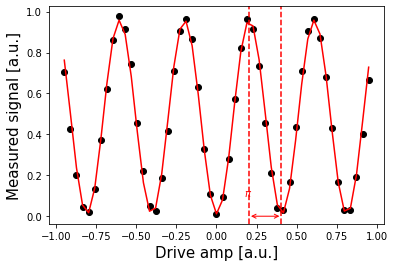

In [284]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit


fit_params, y_fit = fit_function(amplitudes,
                                 exp_vals, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.5, 0])

plt.scatter(amplitudes, exp_vals, color='black')
plt.plot(amplitudes, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [282]:
pi_amp = abs(drive_period / 2)
print(f"Our Pi amplitude = {pi_amp+0j} and reported: {x_sched.instructions[0][1].pulse.amp}")

Our Pi amplitude = (0.20274691558254032+0j) and reported: (0.1985878439739215+0j)


In [290]:
drag_params["amplitude"] = pi_amp+0j
print(drag_params)

{'duration': 160, 'sigma': 40, 'beta': -0.9962676126094533, 'frequency': 5236472853.419347, 'amplitude': (0.20274691558254032+0j)}


In [361]:
from qiskit.circuit.library import CXGate
from qiskit.circuit import Qubit, QuantumRegister
x_circs = x_gate_circuits(qubit, drag_params, backend)
qreg = QuantumRegister(1)
x_circs.add_register(qreg)
# x_circs.add_bits([Qubit(qreg, 1)])

x_circs.append(CXGate(), [0,1])
x_circs.measure_active()
x_circs.draw()

# custom_x_sched = schedule(tc_x, backend)

┌──────────┐      ░ ┌─┐   
      q_0: ┤ Custom_x ├──■───░─┤M├───
           └──────────┘┌─┴─┐ ░ └╥┘┌─┐
  q6798_0: ────────────┤ X ├─░──╫─┤M├
                       └───┘ ░  ║ └╥┘
measure: 2/═════════════════════╩══╩═
                                0  1

In [364]:
transpiled_test = transpile(x_circs, backend)
transpiled_test.draw()

┌──────────┐      ░ ┌─┐   
      q_0 -> 0 ┤ Custom_x ├──■───░─┤M├───
               └──────────┘┌─┴─┐ ░ └╥┘┌─┐
  q6798_0 -> 1 ────────────┤ X ├─░──╫─┤M├
                           └───┘ ░  ║ └╥┘
ancilla_0 -> 2 ─────────────────────╫──╫─
                                    ║  ║ 
ancilla_1 -> 3 ─────────────────────╫──╫─
                                    ║  ║ 
ancilla_2 -> 4 ─────────────────────╫──╫─
                                    ║  ║ 
ancilla_3 -> 5 ─────────────────────╫──╫─
                                    ║  ║ 
ancilla_4 -> 6 ─────────────────────╫──╫─
                                    ║  ║ 
    measure: 2/═════════════════════╩══╩═
                                    0  1

In [369]:
job = backend.run(x_circs, job_name="simple_cnot", shots=2048)
job_id = job.job_id()
print(job.job_id())

619c8c1953ac6c1c6bd5a514


In [3]:
from qiskit.visualization import plot_histogram

#simple cnot experiment
# jakarta (1:33) 619c8acd53ac6c6f7dd5a511

results = backend.retrieve_job("619c8c1953ac6c1c6bd5a514").result()
# counts = results.get_counts()
# plot_histogram(counts)

In [5]:
print(results.get_counts())

{'00': 12, '01': 107, '10': 64, '11': 1865}


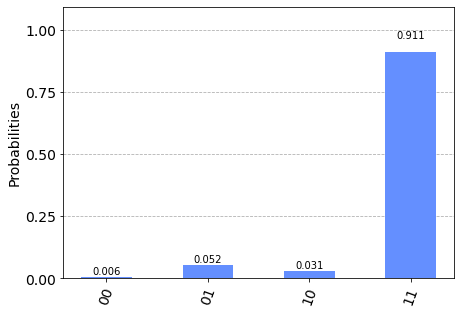

In [6]:
plot_histogram(results.get_counts())